In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Previous version (only protein emb, DNA LM data and sequence features used)
- seq_feats
- lm_3utr_emb
- lm_5utr_emb
- prot_emb

In [2]:
# DNA LM embeddings
#dnalm_df = pd.read_parquet('/s/project/multispecies/fungi_code/motif_discovery_pipeline/data/embeddings_non_sac_upstream/Saccharomyces_cerevisiae_BY4741/sequence_features_and_embeddings_Saccharomyces_cerevisiae_BY4741.parquet')
dnalm_df = pd.read_parquet('data/dnalm_df.parquet')
dnalm_df.head()

,gene_id,embedding_upstream,embedding_downstream,five_prime_seq,cds,three_prime_seq,gc_5_prime,gc_3_prime,gc_cds,AAA,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,species
0,YAL002W,"[0.08123832, 0.030906273, 0.014586483, -0.0152...","[-0.02917197, 0.078893326, -0.05454025, 0.1706...",TTCCAAGGCCGATGAATTCGACTCTTTCCCAGCTGCCTCTGCTGCC...,ATGGAGCAAAATGGCCTTGACCACGACAGCAGATCTAGCATCGATA...,TAACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAA...,0.365902,0.310000,0.372057,0.043956,...,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967,Saccharomyces_cerevisiae_BY4741
1,YAL003W,"[0.032580532, 0.025513712, -0.031748626, -0.04...","[-0.030835396, -0.072578646, -0.05808209, 0.14...",CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...,ATGGCATCCACCGATTTCTCCAAGATTGAAACTTTGAAACAATTAA...,TAAAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAA...,0.372881,0.253333,0.448220,0.009709,...,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854,Saccharomyces_cerevisiae_BY4741
2,YAL004W,"[0.07244772, -0.004530292, 0.08222245, -0.0672...","[-0.032747507, -0.1945743, -0.083140165, 0.042...",CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...,ATGGGTGTCACCAGCGGTGGCCTTAACTTCAAAGATACCGTCTTCA...,TAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTG...,0.417747,0.346667,0.451163,0.023256,...,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000,Saccharomyces_cerevisiae_BY4741
3,YAL008W,"[0.018979808, 0.34264776, -0.0416448, 0.006748...","[0.0005224135, -0.061880764, -0.061566852, 0.1...",GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...,ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGA...,TGAGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCG...,0.381854,0.296667,0.388889,0.045455,...,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404,Saccharomyces_cerevisiae_BY4741
4,YAL009W,"[-0.009528967, 0.003373141, 0.000113023896, -0...","[-0.01995761, -0.24868764, -0.054501917, 0.086...",CAAGATAATGTCAAAGTTAGTGGTCGTCCTGTGTTTGTAGAATGTG...,ATGGAGCCAGAGAGCATAGGCGATGTGGGGAACCATGCCCAGGATG...,TGAAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTA...,0.368893,0.323333,0.414414,0.042471,...,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610,Saccharomyces_cerevisiae_BY4741


In [3]:
# Sequence features
seq_feats = dnalm_df[['gene_id'] + list(dnalm_df.iloc[:, 6:-1].columns)].dropna()
seq_feats.head()

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.006279,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,0.000000,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,0.000000,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.000000,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.003861,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610


In [4]:
# Upstream sequence embedding
lm_5utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_upstream.values), index=dnalm_df.dropna().gene_id)
lm_5utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601


In [5]:
# Downstream sequence embedding
lm_3utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_downstream.values), index=dnalm_df.dropna().gene_id)
lm_3utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.029172,0.078893,-0.054540,0.170680,-0.107067,-0.092142,0.094663,-0.073110,0.010419,0.073653,...,0.078681,0.033648,0.014682,-0.074566,0.052284,0.034215,0.132639,0.110446,-0.013290,0.052378
YAL003W,-0.030835,-0.072579,-0.058082,0.145516,0.149264,-0.134691,0.159887,-0.117146,0.021611,0.060180,...,0.033926,0.019848,-0.004159,-0.071930,0.093962,-0.118783,0.159958,0.053212,-0.016180,-0.016293
YAL004W,-0.032748,-0.194574,-0.083140,0.042409,-0.167408,-0.126880,0.001361,-0.057888,0.031826,0.058797,...,0.064126,0.029112,-0.026013,-0.039213,0.102791,-0.111031,0.153221,0.017565,0.043769,0.003665
YAL008W,0.000522,-0.061881,-0.061567,0.106177,0.190146,-0.093892,0.050411,-0.155466,-0.009316,-0.006226,...,0.088757,0.043351,-0.037464,-0.073037,0.038244,-0.024653,-0.003237,0.044000,0.024346,0.006319
YAL009W,-0.019958,-0.248688,-0.054502,0.086972,0.208853,0.028963,-0.019007,-0.138868,-0.011246,0.009775,...,0.073859,0.001456,-0.025106,-0.022704,0.054237,-0.049160,-0.003523,0.056109,-0.006815,0.032631


In [6]:
# Protein embeddings from ESM2
#dataset = pd.read_pickle("/s/project/semi_supervised_multispecies/Downstream/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/all_w_protein_seqs_embs.pickle")
#prot_emb = pd.DataFrame(np.stack(dataset.protein_emb.dropna().values), index=dataset.gene_id)
prot_emb = pd.read_parquet('data/protein_emb.parquet')
prot_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL037W,0.077271,-0.057495,0.052307,0.074829,0.021423,-0.085205,0.071228,0.095398,0.028702,0.050751,...,0.134277,0.072266,-0.021713,0.066406,0.005680,0.021194,0.082520,-0.128540,-0.082214,-0.041718
YAL016W,0.064758,0.026871,-0.037994,0.045532,-0.023880,-0.051514,0.044617,-0.152832,0.023239,0.023300,...,0.158203,0.056488,-0.054749,0.015411,-0.078064,0.029373,0.055328,-0.112305,-0.038544,0.107849
YAL003W,0.074219,-0.017822,-0.073120,0.050598,0.026871,0.065979,0.068481,-0.242920,0.031342,0.042450,...,0.030151,-0.015701,-0.027069,0.044128,-0.043304,-0.096680,-0.028107,-0.229614,-0.015327,0.076904
YAL053W,-0.002195,-0.014854,-0.033875,0.077026,-0.005131,-0.097351,0.085815,-0.107666,-0.033203,0.048950,...,0.139893,0.009560,-0.075989,0.025589,-0.024933,-0.044464,0.020859,-0.033234,-0.054749,0.038361
YAL031W-A,0.049866,0.035248,0.141846,0.016281,-0.022156,-0.022507,-0.046112,0.180176,0.170898,0.080444,...,0.090759,0.108032,-0.091125,0.139648,-0.069824,0.188232,0.010498,0.062744,-0.078430,0.033264


In [7]:
def zscore_matrix(mat):
    m = np.mean(np.array(mat, dtype=np.float32).flatten())
    sd = np.std(np.array(mat, dtype=np.float32).flatten())

    mat_z = (mat - m)/sd
    return mat_z

In [8]:
%%time

seq_feats = seq_feats.set_index('gene_id')
# seq_feats_z = zscore_matrix(seq_feats)
# seq_feats_z = seq_feats_z.reset_index()

prot_emb_z = zscore_matrix(prot_emb)
prot_emb_z.columns = prot_emb_z.columns.astype(str)
prot_emb_z.columns = 'ESM2_' + prot_emb_z.columns
prot_emb_z = prot_emb_z.reset_index()

lm_3utr_emb_z = zscore_matrix(lm_3utr_emb)
lm_3utr_emb_z.columns = lm_3utr_emb_z.columns.astype(str)
lm_3utr_emb_z.columns = 'LM_3UTR_' + lm_3utr_emb_z.columns
lm_3utr_emb_z = lm_3utr_emb_z.reset_index()

lm_5utr_emb_z = zscore_matrix(lm_5utr_emb)
lm_5utr_emb_z.columns = lm_5utr_emb_z.columns.astype(str)
lm_5utr_emb_z.columns = 'LM_5UTR_' + lm_5utr_emb_z.columns
lm_5utr_emb_z = lm_5utr_emb_z.reset_index()

# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(prot_emb_z, on='gene_id').merge(lm_3utr_emb_z, on='gene_id').merge(lm_5utr_emb_z, on='gene_id')
yeast_emb_full

CPU times: user 628 ms, sys: 204 ms, total: 832 ms
Wall time: 1.02 s


,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,LM_5UTR_758,LM_5UTR_759,LM_5UTR_760,LM_5UTR_761,LM_5UTR_762,LM_5UTR_763,LM_5UTR_764,LM_5UTR_765,LM_5UTR_766,LM_5UTR_767
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.078495,-0.101951,-0.451596,0.140201,-0.027987,-0.139936,0.119334,-0.009675,0.035513,-0.042870
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.036358,-0.086898,-0.285149,0.175611,0.077306,-0.061331,0.043992,0.006744,-0.069993,-0.174272
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,-0.075972,-0.245783,-0.237227,0.035347,0.030442,-0.027595,0.166694,0.106680,0.595686,0.108673
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.041582,-0.064832,-0.376715,0.091384,0.042122,-0.061658,0.052838,0.059197,-0.438873,-0.127666
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,-0.040703,-0.020197,-0.345180,0.086169,0.088264,-0.025787,0.143896,-0.037077,-0.682068,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,0.334995,0.393333,0.467890,0.027523,0.000000,0.000000,0.027523,0.045872,0.009174,...,-0.069516,-0.091421,-0.402476,0.095457,0.023955,-0.072979,-0.082304,0.072628,-0.665834,0.037950
6575,YPR197C,0.376869,0.276667,0.374332,0.058824,0.021390,0.021390,0.016043,0.042781,0.005348,...,-0.014195,-0.102008,-0.424302,0.133435,0.087042,-0.024667,0.205772,0.009731,-0.687237,0.048592
6576,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.052901,-0.037409,-0.385326,0.083647,0.060815,-0.034371,0.054171,0.069161,-0.484573,-0.094109
6577,YPR200C,0.366899,0.313333,0.376923,0.038462,0.015385,0.038462,0.023077,0.030769,0.015385,...,0.087128,-0.082817,-0.418286,0.099563,0.080339,-0.000032,0.105696,0.047736,-0.490977,0.055293


In [9]:

m = np.mean(np.array(lm_3utr_emb_z.iloc[:,1:], dtype=np.float32).flatten())
sd = np.std(np.array(lm_3utr_emb_z.iloc[:,1:], dtype=np.float32).flatten())
print(m,sd)

-1.1842807e-08 1.0000001


0.8445516862280227


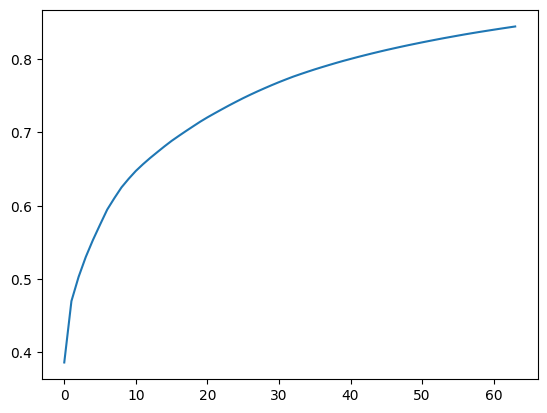

In [10]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [11]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,1.350518,-2.705953,-1.249147,-0.884463,0.093777,-3.918616,-1.101292,-0.525820,-0.365258,...,-0.372327,0.131501,0.054134,-0.097874,0.615863,-0.036956,0.422214,0.500798,0.158755,-0.172458
1,YAL003W,7.801300,-1.138063,-0.104988,-1.874635,0.463608,4.607939,-0.764479,-2.198857,-1.092609,...,-0.143448,0.821036,-0.186968,-0.258429,-0.527343,0.004280,0.196959,0.017762,-1.038202,-0.761103
2,YAL004W,-8.824801,5.049178,4.525735,-1.249379,-0.547005,0.965001,0.615475,0.441012,-0.987946,...,-0.771198,-0.325363,0.206845,-0.726093,-0.744297,0.488100,1.444117,-0.258906,0.298152,-1.156198
3,YAL008W,1.003984,-4.439332,-2.055461,-2.095814,-0.039439,-0.533439,-2.068278,-1.012841,-2.278583,...,0.118573,-0.295434,-0.105219,-0.173459,-0.317619,-0.056633,0.276479,-0.228171,-0.100574,-0.323901
4,YAL009W,0.317848,-2.682067,-1.796905,-0.984867,-0.965357,1.003266,-0.912031,1.055314,-0.916025,...,-0.320669,0.543929,0.130487,-0.306718,0.424755,0.304276,-0.394484,-0.578451,0.375980,-0.310530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,-12.959321,2.593324,-2.731855,1.928469,-0.405484,2.816277,1.141237,1.486669,-1.403696,...,0.783472,0.101996,1.313591,-0.568289,0.163047,-0.143965,-0.190673,0.583015,0.382760,0.024470
6575,YPR197C,-10.684675,8.455941,6.477363,-4.848729,-0.594108,2.483717,-3.985001,-2.043341,3.759298,...,1.060881,0.985162,-0.883959,-0.010360,0.864133,1.457280,0.567385,-0.235015,0.533814,0.239919
6576,YPR199C,-4.017440,-2.991633,0.940513,0.920400,0.986334,0.223407,-2.316896,0.581107,1.129787,...,0.065939,-0.117908,0.176862,-0.082706,-0.245125,0.401993,0.500395,0.383070,-0.848077,0.114612
6577,YPR200C,4.573682,-0.580103,-2.770326,-1.135877,0.678429,0.205747,-1.006403,-0.226968,0.700998,...,-0.211324,0.362402,-0.675641,0.014188,-0.633434,0.591568,-0.009425,-0.776419,0.681627,-0.763972


# Load the data, that is needed to be incorporated as well
- experimental gene-gene interaction by Costazo et al 2016 
- gene expression and fitness data
- Yeast Net

In [12]:
# Gene expression and fitness data
data_experiment_decriptions = pd.read_csv('data/yp_screens_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco = pd.read_csv('data/yp_matrix_z_haphom_20221025.txt', sep = '\t', index_col = 0)

In [13]:
# Gene-gene interactions, they need to be combined, cause separatedly for essential and non-essential genes
GxG_data_Costanzo_ExE = pd.read_csv('data/SGA_ExE_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_ExN = pd.read_csv('data/SGA_ExN_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_NxN = pd.read_csv('data/SGA_NxN_clustered.cdt', sep = '\t', dtype = 'str')

In [14]:
def cdt_to_mat(cdt):
    mat = cdt.iloc[5:, 6:].astype(np.float64)
    mat.columns = cdt.iloc[1, 6:]
    return mat.set_index(cdt["ORF"].iloc[5:])

ExE = cdt_to_mat(GxG_data_Costanzo_ExE)
ExN = cdt_to_mat(GxG_data_Costanzo_ExN)
NxN = cdt_to_mat(GxG_data_Costanzo_NxN)

In [15]:
all_genes = sorted(set(ExE.index).union(ExE.columns).union(ExN.index).union(ExN.columns).union(NxN.index).union(NxN.columns))
ExE_ = ExE.loc[~ExE.index.duplicated(),~ExE.columns.duplicated()].reindex(index=all_genes, columns=all_genes)
ExN_ = ExN.loc[~ExN.index.duplicated(),~ExN.columns.duplicated()].reindex(index=all_genes, columns=all_genes)
NxN_ = NxN.loc[~NxN.index.duplicated(),~NxN.columns.duplicated()].reindex(index=all_genes, columns=all_genes)

In [16]:
GxG = ExE_.fillna(0) + ExN_.fillna(0) + NxN_.fillna(0)
GxG[(ExE_.isna() & ExN_.isna() & NxN_.isna())] = np.nan

In [17]:
# Yeast Net data
YeastNetdata = pd.read_csv('data/YeastNet.csv', sep = ',', index_col = 0)

In [18]:
YeastNetdata.head()

,gene1,gene2,edge_value
0,YBL039C,YGR103W,3.713364
1,YDL060W,YDR101C,3.701611
2,YDL060W,YNL248C,3.693862
3,YDR101C,YOR004W,3.665467
4,YDL148C,YNL062C,3.660805


In [19]:
node_count = len(np.unique(np.concatenate([YeastNetdata.gene1, YeastNetdata.gene2])))
print(f"{len(YeastNetdata)/(node_count**2) * 100} % edges")

0.7386006109725306 % edges


In [20]:
YeastNetdata.to_csv("data/YeastNet.edg", sep="\t", columns=["gene1", "gene2", "edge_value"], header=False, index=False)

In [23]:
!pecanpy --input "data/YeastNet.edg" --output "data/YeastNetEmbeddings.npz" --mode SparseOTF --weighted

/Users/lukasveskrna/Developer/Notebooks/yeast-embeddings/venv/lib/python3.12/site-packages/pecanpy/cli.py:302: UserWarning: When p = 1 and q = 1, it is highly recommended to use PreCompFirstOrder over SparseOTF (current selection). The runtime could be improved greatly with low memory usage.
  check_mode(g, args)
Took 00:00:01.49 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:00:20.53 to generate walks
Took 00:00:13.17 to train embeddings


In [21]:
yeastnet_embeddings_npz = np.load("data/YeastNetEmbeddings.npz")
yeastnet_embeddings = pd.DataFrame(np.stack(yeastnet_embeddings_npz["data"]), index=yeastnet_embeddings_npz["IDs"]).add_prefix("yeastnet_")
yeastnet_embeddings

yeastnet_emb_z = zscore_matrix(yeastnet_embeddings)
yeastnet_emb_z.columns = yeastnet_emb_z.columns.astype(str)
yeastnet_emb_z = yeastnet_emb_z.reset_index()
yeastnet_emb_z.rename(columns={'index':'gene_id'}, inplace=True)

# m = np.mean(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# sd = np.std(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# print(m, sd)

yeastnet_emb_z

,gene_id,yeastnet_0,yeastnet_1,yeastnet_2,yeastnet_3,yeastnet_4,yeastnet_5,yeastnet_6,yeastnet_7,yeastnet_8,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YBR247C,-1.385324,-1.113846,0.935908,-0.518301,1.081061,0.084619,-1.606464,-0.238198,0.455896,...,1.017153,0.296500,0.835789,-0.559069,0.590425,0.055117,-0.471596,-0.112860,0.371423,0.454585
1,YBL039C,-1.122144,-0.305544,0.913279,-0.529993,1.197200,-0.195073,-1.797255,0.490908,0.801900,...,0.887956,-0.992966,0.516213,-1.068361,0.493973,0.664601,-0.971133,0.790225,0.443095,0.711463
2,YDL060W,-1.134854,-1.201190,1.377055,-1.022398,1.401706,-0.319838,-1.412018,0.202701,-0.187166,...,1.098455,-0.356739,0.641035,-0.025331,0.206952,-0.074126,-0.755676,-0.327953,-0.095726,-0.098172
3,YBR142W,-1.021143,-0.778750,1.379316,-0.741958,1.410835,-0.172395,-1.313821,0.020362,0.493558,...,1.478639,-0.722646,0.740216,-0.399745,0.778816,-0.398456,-0.589399,-0.011865,0.543913,0.454531
4,YAL059W,-0.652155,-1.468303,0.513806,-1.388162,1.110647,0.400635,-1.636000,0.004501,-0.078763,...,0.506233,-0.845132,0.251711,0.513264,0.369560,0.429594,0.121117,-0.134520,0.728055,-0.198051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,YDR014W,-0.212491,-0.062965,0.461400,-0.381069,0.380621,-0.416885,0.390048,-0.202495,-0.252529,...,0.761626,-0.408580,-0.528512,0.040383,0.981567,0.099944,0.268959,-0.240120,0.265751,0.553537
5726,YOR293C-A,-0.378216,-0.258625,0.108727,-0.295076,0.326956,-0.358099,0.397832,0.079092,0.460155,...,0.423492,-0.130712,-0.273370,0.272583,0.583636,-0.249891,0.121913,-0.233841,0.077675,0.468329
5727,YBR296C-A,-0.582961,-0.379060,0.240526,-0.425186,0.487941,-0.429467,-0.211331,0.341904,0.472408,...,0.657701,-0.112219,-0.115964,-0.048170,0.203128,-0.111519,-0.378532,-0.054962,0.183265,0.029746
5728,YDR040C,-0.303825,-0.104511,0.495901,-0.533697,0.173627,-0.423376,0.200459,-0.189657,-0.272367,...,0.638354,-0.515761,-0.347143,0.041587,0.928520,0.015472,0.184002,-0.144841,0.466713,0.435914


In [22]:
# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(yeast_emb_full, on='gene_id').merge(yeastnet_emb_z, on='gene_id')
yeast_emb_full

,gene_id,gc_5_prime_x,gc_3_prime_x,gc_cds_x,AAA_x,AAC_x,AAG_x,AAT_x,ACA_x,ACC_x,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.404030,-0.325246,-0.051472,1.036798,0.522501,-0.443763,0.242050,-0.495737,-0.310430,0.548839
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.346361,-0.741545,0.856430,-0.461795,0.750900,0.633918,-1.189885,0.538969,0.876069,0.043686
2,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.004656,-1.195575,-0.144611,0.056151,-0.106231,0.392002,-0.757325,-0.866014,-0.437098,0.608646
3,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.567920,0.296521,-1.447339,0.879642,1.271222,-0.277654,1.061236,-0.014637,-0.770365,0.492830
4,YAL011W,0.461615,0.346667,0.416533,0.078400,0.014400,0.057600,0.030400,0.009600,0.019200,...,0.655904,-0.348880,-0.069905,0.819442,1.190199,-0.330729,0.597684,-0.860345,0.336234,0.601920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,YPR190C,0.408774,0.323333,0.388889,0.048930,0.019878,0.032110,0.027523,0.019878,0.013761,...,1.129924,-0.238508,0.282226,0.238912,0.131135,-0.183400,-0.955997,-0.018910,0.556186,-0.539162
5680,YPR193C,0.356929,0.363333,0.412393,0.051282,0.051282,0.038462,0.012821,0.006410,0.012821,...,0.347161,-0.647885,-0.028369,-0.569804,0.860936,-0.282014,-0.416752,-1.019944,0.220593,0.658871
5681,YPR194C,0.347956,0.323333,0.373242,0.037628,0.013683,0.019384,0.041049,0.017104,0.009122,...,0.517848,0.154430,-1.425005,0.889497,1.045975,0.943919,0.819417,-1.093202,-0.404235,-0.360619
5682,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.096879,-0.211057,-0.702862,1.093303,1.625670,0.414341,0.855135,-1.116282,0.125933,0.205539


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def eval_with_Costanzo_GxG(emb, reduced_count=10_000, test_size=0.1, random_state=42):
    data = GxG.stack(future_stack=True).dropna()
    if reduced_count is not None:
        data = data[:reduced_count]
        
    gene_pairs = data.index.to_frame().reset_index(drop=True)
    gene_pairs.columns = ["gene1", "gene2"]
    gene_pairs = gene_pairs.assign(interaction=pd.Series(np.array(data)))
    
    gene_pairs_emb = gene_pairs.merge(emb, left_on="gene1", right_on="gene_id").merge(emb, left_on="gene2", right_on="gene_id").drop(["gene1", "gene2", "gene_id_x", "gene_id_y"], axis=1)
    y = gene_pairs_emb.interaction
    X = gene_pairs_emb.drop(["interaction"], axis=1)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    reg = LinearRegression()
    reg.fit(train_X, train_y)

    pred_y = reg.predict(test_X)
    print("Costanzo GxG eval MSE:", mean_squared_error(test_y, pred_y), "R2:", r2_score(test_y, pred_y))


In [69]:
eval_with_Costanzo_GxG(yeast_emb_full)

Costanzo GxG eval MSE: 0.005440798871112025 R2: -0.6530647189103962


0.823041823889974


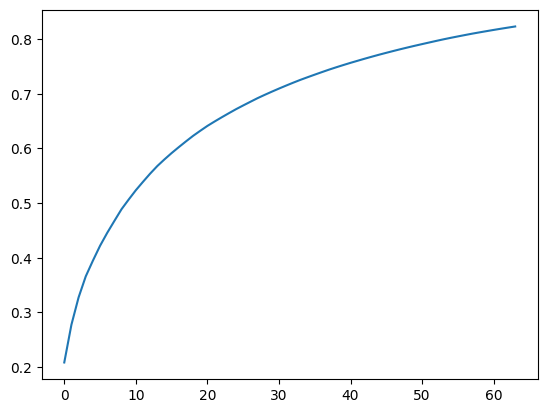

In [25]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [26]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca.columns = emb_full_pca.columns.astype(str)
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,-1.740230,-4.256127,-0.582496,-1.202931,0.530763,-1.068007,-3.021700,0.317479,-0.272087,...,-0.112143,-1.481699,0.838201,0.110342,-0.388644,0.459508,-1.828895,1.679900,-2.088111,-0.199443
1,YAL003W,7.759533,7.228523,4.715414,-4.729938,1.542565,1.633074,-1.755238,1.163742,-0.795585,...,0.272168,0.652883,0.402149,0.371829,-1.159301,0.028039,-0.387131,0.614821,-0.313718,-0.554892
2,YAL008W,-1.669045,-4.190044,1.321047,-6.393245,-1.086397,-1.507638,-2.119801,0.261032,-1.430936,...,-0.767084,-0.576853,0.720924,0.621471,-2.465893,0.129479,-0.475856,-0.287118,-1.600494,-0.067187
3,YAL009W,-2.092339,0.456134,-2.630738,-2.505065,-1.516441,4.204993,0.007717,-0.441315,3.066261,...,-0.564013,-0.105903,-0.428763,-0.236559,-0.038879,-0.827329,0.674724,-0.665803,-0.103950,0.135052
4,YAL011W,-8.471317,2.199790,-1.617738,-3.014491,2.399004,0.002357,0.739567,0.387305,0.251560,...,0.104508,-0.951745,0.556352,-0.986523,-0.500173,-0.388909,-0.080281,-0.302376,-0.435133,-0.448003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,YPR190C,-0.522772,7.630161,-1.699364,-0.013230,-0.122830,-4.111982,0.103323,0.309713,-1.221874,...,0.125889,-0.216151,-0.699476,-1.307447,-0.298703,0.168507,0.143600,0.282189,0.663864,-0.251018
5680,YPR193C,7.576836,-5.790900,0.650827,-0.148808,-1.489279,-0.425344,0.084033,1.754333,-0.362454,...,-0.819126,0.341761,-0.035323,0.992826,0.959764,-0.464093,-1.584191,-0.429693,0.131179,0.320049
5681,YPR194C,5.941454,-2.381700,0.620427,3.927621,1.195012,0.050619,-3.261553,-5.236406,1.128540,...,0.165009,0.705973,1.232050,-0.537483,0.772926,-0.137585,-0.326817,0.048619,1.305024,1.585349
5682,YPR199C,-7.236179,-2.167064,0.070999,1.306639,0.814836,-1.494223,-1.102415,-0.712238,-2.168237,...,0.366108,-0.111949,0.816182,-0.050683,1.164321,1.555460,0.694422,-0.294139,0.405698,-0.111559


# Simple evaluation on siingle mutant fitness data

In [27]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('data/smf.csv', index_col = 0)

<Axes: >

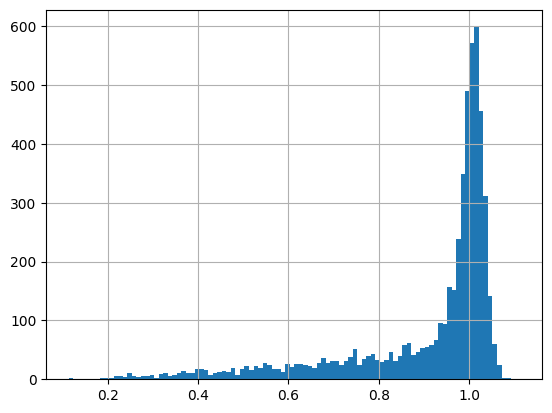

In [28]:
smf_filter.smf_30.hist(bins=100)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

R2:   0.19905739010659163
MSE:  0.027099450531180857


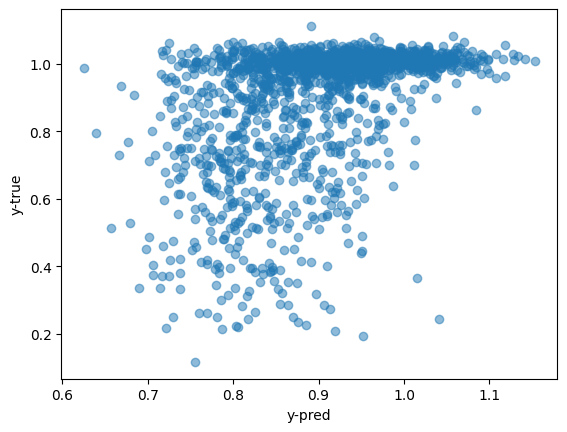

In [30]:
# How predictive are sequence features?

A = smf_filter.merge(emb_full_pca, on='gene_id').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2:  ', lm.score(X_test, y_test))
print('MSE: ', mean_squared_error(y_test, lm.predict(X_test)))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()

In [31]:
# Save full embedding 
yeast_emb_full.to_parquet("data/yeast_emb_full.parquet")

In [32]:
# Save yeastNet Embedding
yeastnet_emb_z.to_parquet("data/yeastnet_emb_z.parquet")